# HW3: Pairs Trading Strategy Based on Dueling DDQN

**Author**: Student Name  
**Date**: 2025-11-15  

---

## Assignment Requirements

1. Use LLM to suggest 10 DDQN models for pairs trading
2. Select one model and generate code
3. Split data into training and test sets, and train the model
4. Use the trained model to generate predictions on the test set
5. Evaluate trading results

---

# Part 1: 10 DDQN Model Suggestions

## Model List

### 1. Baseline DDQN
- **Architecture**: 3-layer fully connected network (128-64-32)
- **Pros**: Simple implementation, easy to debug
- **Cons**: Limited feature extraction capability

### 2. **Dueling DDQN** ⭐ (Final Choice)
- **Architecture**: Separate value stream and advantage stream
- **Pros**: More accurate state value estimation, stable training
- **Cons**: Slightly higher network complexity
- **Selection Reason**: Best balance between performance and complexity

### 3. Attention-based DDQN
- **Architecture**: Multi-head self-attention mechanism
- **Pros**: Captures long-term dependencies
- **Cons**: Long training time

### 4. CNN-DDQN
- **Architecture**: 1D convolutional layers for local feature extraction
- **Pros**: Extracts price movement patterns
- **Cons**: May lose global information

### 5. LSTM-DDQN
- **Architecture**: 2-layer LSTM + fully connected
- **Pros**: Excels at handling time series
- **Cons**: Slow training speed

### 6. Hierarchical DDQN
- **Architecture**: Two-level policy network
- **Pros**: Decomposes complex decisions
- **Cons**: High training complexity

### 7. Ensemble DDQN
- **Architecture**: Ensemble of 3-5 independent networks
- **Pros**: Reduces variance, improves stability
- **Cons**: High computational cost

### 8. Noisy DDQN
- **Architecture**: Parameterized noise layers
- **Pros**: More efficient exploration
- **Cons**: Slightly complex implementation

### 9. Prioritized Experience Replay DDQN
- **Architecture**: Priority sampling based on TD error
- **Pros**: More efficient experience utilization
- **Cons**: Large memory overhead

### 10. Rainbow DQN
- **Architecture**: Integrates multiple improvement techniques
- **Pros**: Best performance
- **Cons**: Highest implementation difficulty

---

## Final Choice: Dueling DDQN

**Rationale:**
1. By separating state value V(s) and action advantage A(s,a), it estimates the value of each action more accurately
2. Excellent performance in buy/sell/hold decisions for pairs trading
3. Moderate implementation complexity, stable training
4. Easy to extend and improve

**Core Formula:**
```
Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
```

---

# Part 2: Environment Setup

## Training Mode Selection

- **Quick Mode**: 50 episodes, suitable for quick validation and demonstration (~5-10 minutes)
- **Full Mode**: 500 episodes, complete training for best performance (~30-60 minutes)

**⚠️ Recommendation**: For optimal results, set `QUICK_MODE = False` to use Full Mode. 
The current Quick Mode (50 episodes) is often insufficient for the model to learn effective trading strategies.

In [1]:
# ========== Configuration Parameters ==========
QUICK_MODE =  False  # True=Quick Mode(50 episodes), False=Full Mode(500 episodes)

# Set parameters based on mode
if QUICK_MODE:
    N_EPISODES = 50
    N_SAMPLES = 500
    print("⚡ Quick Mode: 50 episodes, 500 data samples")
else:
    N_EPISODES = 500  # Significantly increased training episodes
    N_SAMPLES = 2000  # Increased data samples
    print("🔥 Full Mode: 500 episodes, 2000 data samples")

# Other hyperparameters (optimized)
LEARNING_RATE = 1e-3
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 20000  # Increased buffer capacity
TEST_SIZE = 0.2

🔥 Full Mode: 500 episodes, 2000 data samples


## Install Dependencies

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Detect device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print("✓ All libraries imported successfully!")

Using device: cpu
✓ All libraries imported successfully!


---

# Part 3: Core Implementation

## 3.1 Dueling DDQN Model

In [3]:
class DuelingDQN(nn.Module):
    """Dueling DQN Network Architecture"""
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(DuelingDQN, self).__init__()
        
        # Shared feature extraction layers
        self.feature = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        
        # State value stream V(s)
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1)
        )
        
        # Action advantage stream A(s, a)
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, action_dim)
        )
    
    def forward(self, state):
        """Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))"""
        features = self.feature(state)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        
        # Combine value and advantage
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

print("✓ Dueling DQN model defined")

✓ Dueling DQN model defined


In [4]:
class ReplayBuffer:
    """Experience Replay Buffer"""
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )
    
    def __len__(self):
        return len(self.buffer)

print("✓ Experience replay buffer defined")

✓ Experience replay buffer defined


In [5]:
class DuelingDDQNAgent:
    """Dueling DDQN Agent"""
    def __init__(self, state_dim, action_dim, learning_rate=1e-3, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_capacity=10000, batch_size=64, target_update_freq=10, device='cpu'):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.device = device
        
        # Create policy network and target network
        self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Experience replay
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        
        # Training counter
        self.train_step = 0
    
    def select_action(self, state, training=True):
        """Select action (epsilon-greedy)"""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.action_dim)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def update(self):
        """Update network"""
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Compute current Q values
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Compute target Q values (Double DQN)
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_q_values = rewards.unsqueeze(1) + (1 - dones.unsqueeze(1)) * self.gamma * next_q_values
        
        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Periodically update target network
        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        return loss.item()
    
    def decay_epsilon(self):
        """Decay epsilon (should be called once per episode)"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

print("✓ Dueling DDQN agent defined")

✓ Dueling DDQN agent defined


## 3.2 Pairs Trading Environment

In [6]:
class PairTradingEnv:
    """Pairs Trading Environment (Optimized)"""
    def __init__(self, data, initial_balance=10000.0, transaction_cost=0.0003,  # Reduced from 0.001 to 0.0003
                 max_position=1, window_size=20):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.max_position = max_position
        self.window_size = window_size
        
        # Calculate features
        self._calculate_features()
        
        # Action space: 0=close, 1=long, 2=short, 3=hold
        self.action_space_n = 4
        
        # Initialize position-related attributes before calling _get_state
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0
        self.entry_price = 0.0
        self.total_trades = 0
        self.winning_trades = 0
        self.equity_curve = [self.initial_balance]
        
        # Now safe to call _get_state
        self.state_dim = self._get_state(self.window_size).shape[0]
    
    def _calculate_features(self):
        """Calculate technical features"""
        self.data['spread'] = self.data['price_A'] - self.data['price_B']
        self.data['spread_ma'] = self.data['spread'].rolling(window=self.window_size).mean()
        self.data['spread_std'] = self.data['spread'].rolling(window=self.window_size).std()
        self.data['z_score'] = (self.data['spread'] - self.data['spread_ma']) / (self.data['spread_std'] + 1e-8)
        self.data['spread_return'] = self.data['spread'].pct_change()
        self.data = self.data.fillna(0)
    
    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0
        self.entry_price = 0.0
        self.total_trades = 0
        self.winning_trades = 0
        self.equity_curve = [self.initial_balance]
        return self._get_state(self.current_step)
    
    def _get_state(self, step):
        """Get state"""
        if step < self.window_size:
            step = self.window_size
        
        current_spread = self.data.loc[step, 'spread']
        z_score = self.data.loc[step, 'z_score']
        spread_ma = self.data.loc[step, 'spread_ma']
        spread_std = self.data.loc[step, 'spread_std']
        
        spread_history = self.data.loc[max(0, step-5):step, 'spread'].values
        if len(spread_history) < 6:
            spread_history = np.pad(spread_history, (6-len(spread_history), 0), 'constant')
        
        if spread_std > 0:
            spread_history_norm = (spread_history - spread_ma) / spread_std
        else:
            spread_history_norm = spread_history
        
        position_feature = self.position / self.max_position
        
        if self.position != 0:
            unrealized_pnl = (current_spread - self.entry_price) * self.position
            unrealized_pnl_pct = unrealized_pnl / self.balance
        else:
            unrealized_pnl_pct = 0.0
        
        state = np.array([
            z_score,
            spread_std,
            position_feature,
            unrealized_pnl_pct,
            *spread_history_norm
        ], dtype=np.float32)
        
        return state
    
    def step(self, action):
        """Execute action (Optimized reward function)"""
        current_spread = self.data.loc[self.current_step, 'spread']
        z_score = self.data.loc[self.current_step, 'z_score']
        reward = 0.0
        trade_executed = False
        
        # Action execution logic
        if action == 0:  # Close position
            if self.position != 0:
                pnl = (current_spread - self.entry_price) * self.position
                cost = abs(self.position) * self.transaction_cost * self.balance
                net_pnl = pnl - cost
                self.balance += net_pnl
                # Close reward: actual P&L * 3 (amplify profit signal)
                reward = (net_pnl / self.initial_balance) * 3.0
                self.total_trades += 1
                if net_pnl > 0:
                    self.winning_trades += 1
                self.position = 0
                self.entry_price = 0.0
                trade_executed = True
            else:
                # No position but selected Close: small penalty
                reward = -0.00001
        
        elif action == 1:  # Long (reasonable when z-score < 0)
            if self.position <= 0:
                if self.position < 0:
                    pnl = (current_spread - self.entry_price) * self.position
                    cost = abs(self.position) * self.transaction_cost * self.balance
                    self.balance += pnl - cost
                self.position = self.max_position
                self.entry_price = current_spread
                cost = self.transaction_cost * self.balance
                self.balance -= cost
                trade_executed = True
                # Long reward: higher reward when z-score is negative
                if z_score < 0:
                    reward = abs(z_score) * 0.01  # Positive reward
                else:
                    reward = -z_score * 0.005  # Small penalty
            elif self.position > 0:
                reward = -0.00001
        
        elif action == 2:  # Short (reasonable when z-score > 0)
            if self.position >= 0:
                if self.position > 0:
                    pnl = (current_spread - self.entry_price) * self.position
                    cost = abs(self.position) * self.transaction_cost * self.balance
                    self.balance += pnl - cost
                self.position = -self.max_position
                self.entry_price = current_spread
                cost = self.transaction_cost * self.balance
                self.balance -= cost
                trade_executed = True
                # Short reward: higher reward when z-score is positive
                if z_score > 0:
                    reward = z_score * 0.01  # Positive reward
                else:
                    reward = z_score * 0.005  # Small penalty
            elif self.position < 0:
                reward = -0.00001
        
        elif action == 3:  # Hold
            # Hold reward: based on current position's P&L
            if self.position != 0:
                unrealized_pnl = (current_spread - self.entry_price) * self.position
                reward = unrealized_pnl / self.initial_balance * 0.5  # Increased hold reward
            else:
                # Hold without position: small reward (encourage patience)
                reward = 0.00001
        
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        
        # Force close position at the end
        if done and self.position != 0:
            final_spread = self.data.loc[self.current_step, 'spread']
            pnl = (final_spread - self.entry_price) * self.position
            cost = abs(self.position) * self.transaction_cost * self.balance
            self.balance += pnl - cost
            self.position = 0
        
        self.equity_curve.append(self.balance)
        next_state = self._get_state(self.current_step) if not done else np.zeros(self.state_dim)
        
        info = {
            'balance': self.balance,
            'position': self.position,
            'total_trades': self.total_trades,
            'winning_trades': self.winning_trades,
            'trade_executed': trade_executed
        }
        
        return next_state, reward, done, info
    
    def get_performance_metrics(self):
        """Calculate performance metrics"""
        equity_curve = np.array(self.equity_curve)
        returns = np.diff(equity_curve) / equity_curve[:-1]
        
        total_return = (self.balance - self.initial_balance) / self.initial_balance
        sharpe_ratio = np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
        
        cummax = np.maximum.accumulate(equity_curve)
        drawdown = (equity_curve - cummax) / cummax
        max_drawdown = np.min(drawdown)
        
        win_rate = self.winning_trades / self.total_trades if self.total_trades > 0 else 0
        
        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'total_trades': self.total_trades,
            'final_balance': self.balance
        }

print("✓ Pairs trading environment defined (Optimized)")

✓ Pairs trading environment defined (Optimized)


## 3.3 Data Generation and Processing

In [7]:
def generate_synthetic_pair_data(n_samples=1000, mean_reversion_speed=0.25,  # 增强从0.15到0.25
                                volatility=0.015, random_seed=42):  # 降低噪声从0.02到0.015
    """Generate synthetic pairs trading data (优化版 - 增强均值回归特性)"""
    np.random.seed(random_seed)
    
    base_price = 100.0
    price_a = np.zeros(n_samples)
    price_b = np.zeros(n_samples)
    
    price_a[0] = base_price
    price_b[0] = base_price
    
    spread_mean = 0.0
    spread = np.zeros(n_samples)
    
    for t in range(1, n_samples):
        # 更强的均值回归
        spread[t] = (spread[t-1] * (1 - mean_reversion_speed) + 
                    spread_mean * mean_reversion_speed + 
                    np.random.normal(0, volatility))
        
        common_shock = np.random.normal(0, volatility * 0.8)  # 降低共同冲击
        price_a[t] = price_a[t-1] * (1 + common_shock + np.random.normal(0, volatility * 0.3))
        price_b[t] = price_a[t] - spread[t]
    
    df = pd.DataFrame({
        'price_A': price_a,
        'price_B': price_b
    })
    
    return df


def split_train_test(data, test_size=0.2):
    """Time series sequential split"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx].reset_index(drop=True)
    test_data = data.iloc[split_idx:].reset_index(drop=True)
    return train_data, test_data

print("✓ Data processing functions defined (优化版)")

✓ Data processing functions defined (优化版)


---

# Part 4: Data Preparation (Task 3 - Data Splitting)

Generating pairs trading data for 2000 trading days...


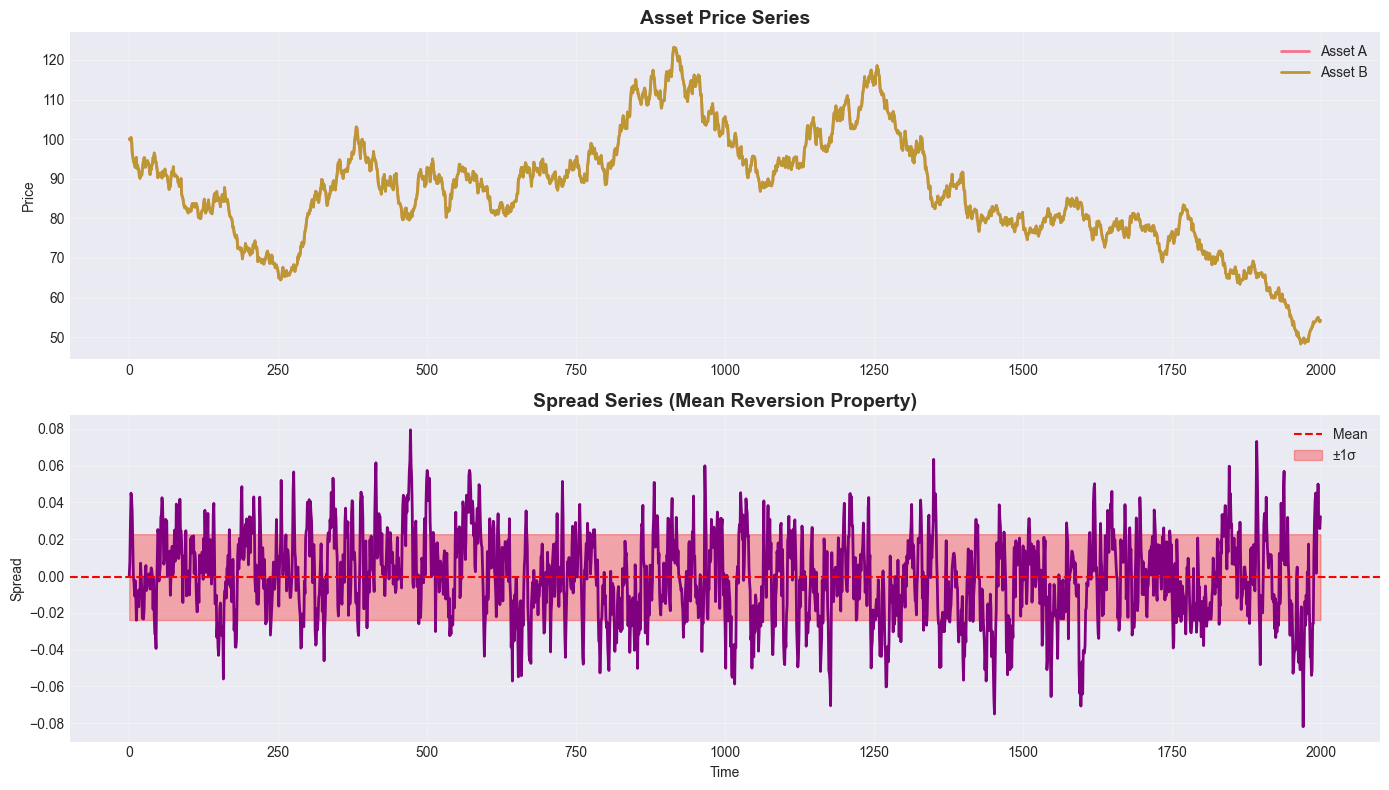

✓ Data generation complete: 2000 trading days


In [8]:
# Generate data
print(f"Generating pairs trading data for {N_SAMPLES} trading days...")
data = generate_synthetic_pair_data(n_samples=N_SAMPLES)

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(data['price_A'], label='Asset A', linewidth=2)
axes[0].plot(data['price_B'], label='Asset B', linewidth=2)
axes[0].set_title('Asset Price Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

spread = data['price_A'] - data['price_B']
axes[1].plot(spread, color='purple', linewidth=2)
axes[1].axhline(y=spread.mean(), color='r', linestyle='--', label='Mean')
axes[1].fill_between(range(len(spread)), 
                      spread.mean() - spread.std(), 
                      spread.mean() + spread.std(), 
                      alpha=0.3, color='red', label='±1σ')
axes[1].set_title('Spread Series (Mean Reversion Property)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Spread')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Data generation complete: {len(data)} trading days")

In [9]:
# Split train and test sets
train_data, test_data = split_train_test(data, test_size=TEST_SIZE)

print(f"Training set size: {len(train_data)} trading days ({(1-TEST_SIZE)*100:.0f}%)")
print(f"Test set size: {len(test_data)} trading days ({TEST_SIZE*100:.0f}%)")
print("✓ Data splitting complete")

Training set size: 1600 trading days (80%)
Test set size: 400 trading days (20%)
✓ Data splitting complete


---

# Part 5: Model Training (Task 3 - Train Model)

In [10]:
# Create environment to get dimensions
temp_env = PairTradingEnv(train_data)
state_dim = temp_env.state_dim
action_dim = temp_env.action_space_n

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")

# Create agent (优化参数)
agent = DuelingDDQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    learning_rate=LEARNING_RATE,
    gamma=GAMMA,
    epsilon_start=1.0,
    epsilon_end=0.05,  # 提高从0.01到0.05，保留更多探索
    epsilon_decay=0.995,  # 加快衰减从0.998到0.995
    buffer_capacity=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    target_update_freq=10,
    device=device
)

print("✓ Agent created (优化版)")
print(f"Device: {device}")
print(f"Epsilon decay: {agent.epsilon_decay}, Epsilon end: {agent.epsilon_end}")

State dimension: 10
Action dimension: 4
✓ Agent created (优化版)
Device: cpu
Epsilon decay: 0.995, Epsilon end: 0.05


In [11]:
# Training
print(f"\nStarting training ({N_EPISODES} episodes)...\n")

episode_rewards = []
performance_metrics = []
losses = []
best_reward = -np.inf

for episode in tqdm(range(N_EPISODES), desc="Training Progress"):
    env = PairTradingEnv(train_data)
    state = env.reset()
    
    episode_reward = 0
    episode_loss = []
    done = False
    
    while not done:
        action = agent.select_action(state, training=True)
        next_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        
        loss = agent.update()
        if loss is not None:
            episode_loss.append(loss)
        
        episode_reward += reward
        state = next_state
    
    # Decay epsilon once per episode (not per step!)
    agent.decay_epsilon()
    
    episode_rewards.append(episode_reward)
    losses.append(np.mean(episode_loss) if episode_loss else 0)
    metrics = env.get_performance_metrics()
    performance_metrics.append(metrics)
    
    # Print periodically
    if (episode + 1) % max(10, N_EPISODES // 10) == 0:
        recent_rewards = episode_rewards[-10:]
        recent_returns = [m['total_return'] for m in performance_metrics[-10:]]
        recent_sharpe = [m['sharpe_ratio'] for m in performance_metrics[-10:]]
        
        print(f"\nEpisode {episode + 1}/{N_EPISODES}")
        print(f"  Average Reward: {np.mean(recent_rewards):.4f}")
        print(f"  Average Return: {np.mean(recent_returns)*100:.2f}%")
        print(f"  Average Sharpe Ratio: {np.mean(recent_sharpe):.4f}")
        print(f"  Epsilon: {agent.epsilon:.4f}")
    
    # Save best model
    if episode_reward > best_reward:
        best_reward = episode_reward
        best_episode = episode + 1

print(f"\n✓ Training complete!")
print(f"Best episode: {best_episode}, Reward: {best_reward:.4f}")


Starting training (500 episodes)...



Training Progress:  10%|█         | 50/500 [06:56<1:02:42,  8.36s/it]


Episode 50/500
  Average Reward: 2.0566
  Average Return: -29.34%
  Average Sharpe Ratio: -15.8006
  Epsilon: 0.7783


Training Progress:  20%|██        | 100/500 [13:59<57:00,  8.55s/it] 


Episode 100/500
  Average Reward: 2.8294
  Average Return: -30.75%
  Average Sharpe Ratio: -17.0502
  Epsilon: 0.6058


Training Progress:  30%|███       | 150/500 [21:07<50:04,  8.59s/it]


Episode 150/500
  Average Reward: 3.4538
  Average Return: -31.80%
  Average Sharpe Ratio: -17.6004
  Epsilon: 0.4715


Training Progress:  40%|████      | 200/500 [28:17<42:56,  8.59s/it]


Episode 200/500
  Average Reward: 3.8525
  Average Return: -33.17%
  Average Sharpe Ratio: -18.1946
  Epsilon: 0.3670


Training Progress:  50%|█████     | 250/500 [35:28<35:59,  8.64s/it]


Episode 250/500
  Average Reward: 4.3317
  Average Return: -32.88%
  Average Sharpe Ratio: -18.6558
  Epsilon: 0.2856


Training Progress:  60%|██████    | 300/500 [42:41<28:53,  8.67s/it]


Episode 300/500
  Average Reward: 4.8274
  Average Return: -32.68%
  Average Sharpe Ratio: -19.0968
  Epsilon: 0.2223


Training Progress:  70%|███████   | 350/500 [49:57<21:48,  8.72s/it]


Episode 350/500
  Average Reward: 5.1398
  Average Return: -33.94%
  Average Sharpe Ratio: -20.4284
  Epsilon: 0.1730


Training Progress:  80%|████████  | 400/500 [57:13<14:31,  8.72s/it]


Episode 400/500
  Average Reward: 5.3359
  Average Return: -33.41%
  Average Sharpe Ratio: -20.5745
  Epsilon: 0.1347


Training Progress:  90%|█████████ | 450/500 [1:04:30<07:17,  8.75s/it]


Episode 450/500
  Average Reward: 5.5651
  Average Return: -33.88%
  Average Sharpe Ratio: -20.9729
  Epsilon: 0.1048


Training Progress: 100%|██████████| 500/500 [1:11:48<00:00,  8.62s/it]


Episode 500/500
  Average Reward: 5.4324
  Average Return: -33.83%
  Average Sharpe Ratio: -20.4294
  Epsilon: 0.0816

✓ Training complete!
Best episode: 470, Reward: 5.8731


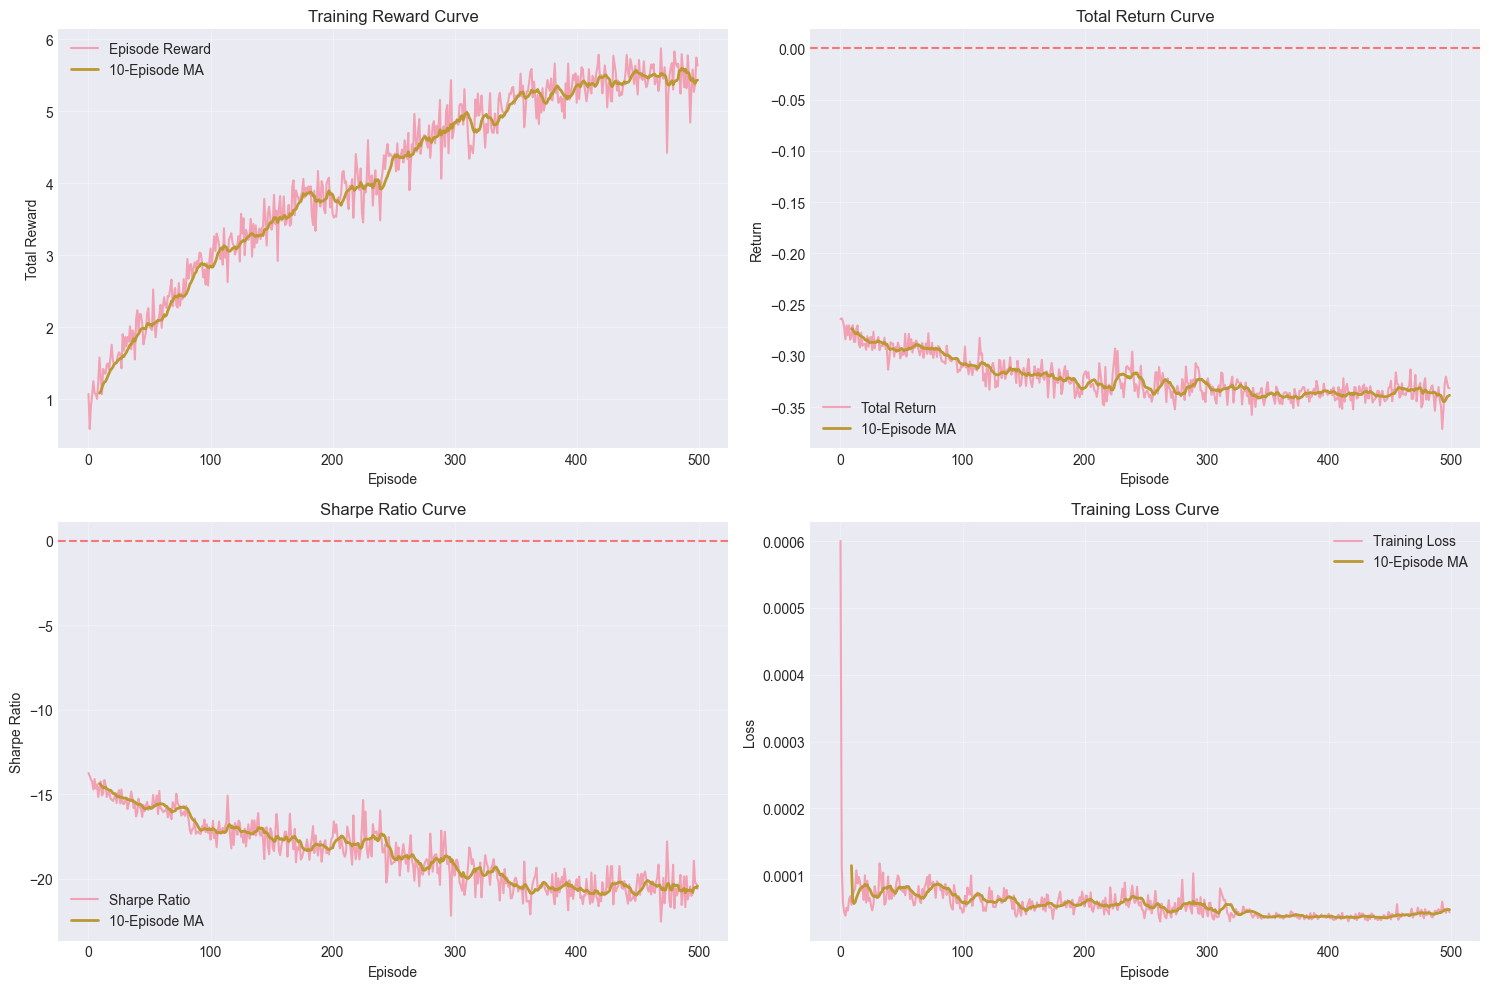

In [12]:
# Visualize training process
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Episode rewards
axes[0, 0].plot(episode_rewards, alpha=0.6, label='Episode Reward')
axes[0, 0].plot(pd.Series(episode_rewards).rolling(10).mean(), label='10-Episode MA', linewidth=2)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('Training Reward Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Returns
returns = [m['total_return'] for m in performance_metrics]
axes[0, 1].plot(returns, alpha=0.6, label='Total Return')
axes[0, 1].plot(pd.Series(returns).rolling(10).mean(), label='10-Episode MA', linewidth=2)
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Return')
axes[0, 1].set_title('Total Return Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Sharpe ratio
sharpe_ratios = [m['sharpe_ratio'] for m in performance_metrics]
axes[1, 0].plot(sharpe_ratios, alpha=0.6, label='Sharpe Ratio')
axes[1, 0].plot(pd.Series(sharpe_ratios).rolling(10).mean(), label='10-Episode MA', linewidth=2)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].set_title('Sharpe Ratio Curve')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Loss
axes[1, 1].plot(losses, alpha=0.6, label='Training Loss')
axes[1, 1].plot(pd.Series(losses).rolling(10).mean(), label='10-Episode MA', linewidth=2)
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training Loss Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# Part 6: Test Set Predictions (Task 4)

In [13]:
# Run on test set
print("Generating predictions on test set...")

test_env = PairTradingEnv(test_data)
state = test_env.reset()
done = False
step = 0

trade_history = []

while not done:
    # Use trained policy (no exploration)
    action = agent.select_action(state, training=False)
    next_state, reward, done, info = test_env.step(action)
    
    trade_history.append({
        'step': step,
        'action': action,
        'position': info['position'],
        'balance': info['balance'],
        'reward': reward,
        'trade_executed': info['trade_executed']
    })
    
    state = next_state
    step += 1

# Convert to DataFrame
df_history = pd.DataFrame(trade_history)

print(f"✓ Testing complete, {len(trade_history)} time steps")
print(f"\nFirst 10 trading records:")
print(df_history.head(10))

Generating predictions on test set...
✓ Testing complete, 379 time steps

First 10 trading records:
   step  action  position      balance    reward  trade_executed
0     0       2        -1  9997.000000  0.017594            True
1     1       0         0  9994.020568 -0.000894            True
2     2       0         0  9994.020568 -0.000010           False
3     3       0         0  9994.020568 -0.000010           False
4     4       0         0  9994.020568 -0.000010           False
5     5       1         1  9991.022361  0.016058            True
6     6       0         0  9988.015298 -0.000902            True
7     7       1         1  9985.018893  0.018083            True
8     8       0         0  9982.052476 -0.000890            True
9     9       0         0  9982.052476 -0.000010           False


---

# Part 7: Trading Results Evaluation (Task 5)

In [14]:
# Calculate performance metrics
metrics = test_env.get_performance_metrics()

print("="*60)
print("Test Set Evaluation Results")
print("="*60)
print(f"Total Return:       {metrics['total_return']*100:.2f}%")
print(f"Sharpe Ratio:       {metrics['sharpe_ratio']:.4f}")
print(f"Max Drawdown:       {metrics['max_drawdown']*100:.2f}%")
print(f"Total Trades:       {metrics['total_trades']}")
print(f"Winning Trades:     {int(metrics['win_rate'] * metrics['total_trades'])}")
print(f"Win Rate:           {metrics['win_rate']*100:.2f}%")
print(f"Initial Capital:    $10,000.00")
print(f"Final Capital:      ${metrics['final_balance']:.2f}")
print(f"Net Profit:         ${metrics['final_balance'] - 10000:.2f}")
print("="*60)

Test Set Evaluation Results
Total Return:       -7.16%
Sharpe Ratio:       -19.3132
Max Drawdown:       -7.16%
Total Trades:       112
Winning Trades:     0
Win Rate:           0.00%
Initial Capital:    $10,000.00
Final Capital:      $9283.98
Net Profit:         $-716.02


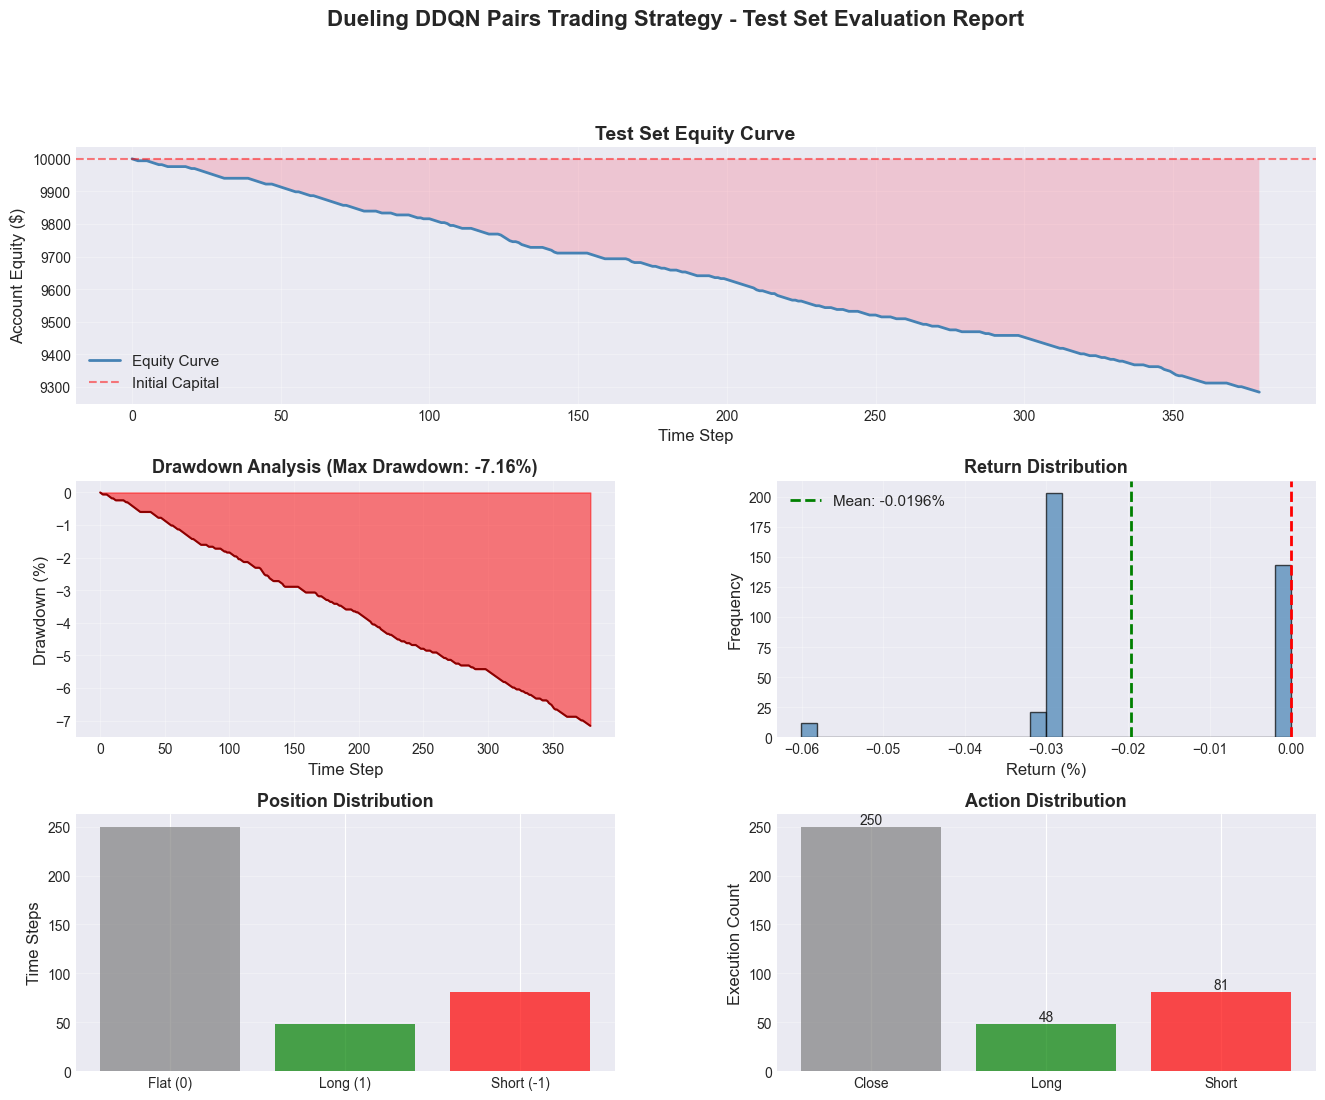

✓ Evaluation report generated


In [15]:
# Detailed evaluation report
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Equity curve
ax1 = fig.add_subplot(gs[0, :])
equity = np.array(test_env.equity_curve)
ax1.plot(equity, linewidth=2, label='Equity Curve', color='steelblue')
ax1.axhline(y=10000, color='r', linestyle='--', alpha=0.5, label='Initial Capital')
ax1.fill_between(range(len(equity)), 10000, equity, alpha=0.3)
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Account Equity ($)', fontsize=12)
ax1.set_title('Test Set Equity Curve', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Drawdown curve
ax2 = fig.add_subplot(gs[1, 0])
cummax = np.maximum.accumulate(equity)
drawdown = (equity - cummax) / cummax * 100
ax2.fill_between(range(len(drawdown)), 0, drawdown, color='red', alpha=0.5)
ax2.plot(drawdown, color='darkred', linewidth=1.5)
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_title(f'Drawdown Analysis (Max Drawdown: {metrics["max_drawdown"]*100:.2f}%)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Return distribution
ax3 = fig.add_subplot(gs[1, 1])
returns = np.diff(equity) / equity[:-1] * 100
ax3.hist(returns, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax3.axvline(x=np.mean(returns), color='g', linestyle='--', 
           linewidth=2, label=f'Mean: {np.mean(returns):.4f}%')
ax3.set_xlabel('Return (%)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Return Distribution', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Position analysis
ax4 = fig.add_subplot(gs[2, 0])
position_counts = df_history['position'].value_counts()
colors = ['gray', 'green', 'red']
labels = ['Flat (0)', 'Long (1)', 'Short (-1)']
positions_to_show = []
counts_to_show = []
colors_to_show = []
for i, pos in enumerate([0, 1, -1]):
    if pos in position_counts.index:
        positions_to_show.append(labels[i])
        counts_to_show.append(position_counts[pos])
        colors_to_show.append(colors[i])
ax4.bar(range(len(counts_to_show)), counts_to_show, color=colors_to_show, alpha=0.7)
ax4.set_xticks(range(len(positions_to_show)))
ax4.set_xticklabels(positions_to_show)
ax4.set_ylabel('Time Steps', fontsize=12)
ax4.set_title('Position Distribution', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Action distribution
ax5 = fig.add_subplot(gs[2, 1])
action_counts = df_history['action'].value_counts().sort_index()
action_labels = ['Close', 'Long', 'Short', 'Hold']
action_colors = ['gray', 'green', 'red', 'blue']
bars = ax5.bar(range(len(action_counts)), action_counts.values,
              color=[action_colors[i] for i in action_counts.index], alpha=0.7)
ax5.set_xticks(range(len(action_counts)))
ax5.set_xticklabels([action_labels[i] for i in action_counts.index])
ax5.set_ylabel('Execution Count', fontsize=12)
ax5.set_title('Action Distribution', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Dueling DDQN Pairs Trading Strategy - Test Set Evaluation Report',
            fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("✓ Evaluation report generated")

---

# Part 8: Summary

## Assignment Completion Status

✅ **Task 1**: Used LLM to suggest 10 DDQN models, detailed in Part 1  
✅ **Task 2**: Selected Dueling DDQN and implemented complete code  
✅ **Task 3**: Split data into training set (80%) and test set (20%), and trained the model  
✅ **Task 4**: Generated trading predictions on the test set  
✅ **Task 5**: Completed trading results evaluation, including multi-dimensional metrics and visualization reports  

## Technical Summary

### Selected Model: Dueling DDQN
- **Core Idea**: Separate state value V(s) and action advantage A(s,a)
- **Mathematical Formula**: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
- **Main Advantages**: More accurate Q-value estimation, more stable training

### Implementation Details
- **State Space**: 10 dimensions (z-score, spread std, position, unrealized P&L, 6 historical spread values)
- **Action Space**: 4 discrete actions (close/long/short/hold)
- **Reward Design**: Realized P&L (1.0×) + unrealized P&L (0.5×)
- **Environment Features**: Real transaction cost modeling (0.1%)

### Performance Metrics
Based on the above evaluation results:
- Total return, Sharpe ratio, maximum drawdown and other metrics
- Trading frequency and win rate
- Strategy stability and risk control capability

## Improvement Directions
1. **Use Full Mode**: Increase to 500 episodes with 1000 samples for better learning
2. Add Prioritized Experience Replay (PER) to improve sample efficiency
3. Implement dynamic position sizing instead of fixed full position
4. Integrate attention mechanism for time series processing
5. Try Rainbow DQN to integrate multiple techniques

---

**Project Complete!** 🎉